<a href="https://colab.research.google.com/github/meliiwamd/OpticalCharacterRecognition/blob/main/OpticalCharacterRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import random
import cv2
import csv

import os
from pathlib import Path
from tqdm import tqdm
import zipfile
import urllib.request

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from IPython.display import SVG

from oauth2client.client import GoogleCredentials
from pydrive.drive import GoogleDrive
from google.colab import drive, auth
from pydrive.auth import GoogleAuth

from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Reshape, BatchNormalization
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np

In [2]:
# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/Deep/OpticalCharacterRecognition/'

# Data Collection
 Attention: This block should be ran only once in order to save the generated dataset to your drive.

In [ ]:
urllib.request.urlretrieve('https://github.com/meliiwamd/OpticalCharacterRecognition/raw/main/Utils.zip', '/content/Utils.zip')
with zipfile.ZipFile('/content/Utils.zip', 'r') as zip_ref:
    zip_ref.extractall(base_dir)

In [ ]:
credit_card_n = 10000
new_national_n = 10000
old_national_n = 10000

## Generate Numbers

In [ ]:
# Generate 16-Digits For Credit Card

credit_card_prefixes = ['6274 12', '6273 81', '5057 85', '6221 06', '6391 94', '6278 84', '6393 47', '5022 29', '6362 14', '6273 53', '5029 08', '6276 48', '2071 77',
                     '6369 49', '5029 38', '5894 63', '6219 86', '5892 10', '6396 07', '6393 46', '5028 06', '6037 69', '6279 61', '6063 73', '6395 99', '6274 88',
                     '5029 10', '6037 70', '6392 17', '5054 16', '6367 95', '6280 23', '6104 33', '9919 75', '6037 99', '6393 70', '6277 60', '6281 57', '5058 01']

def GenerateCreaditCardNumber():

    numbers = []

    i = 0
    while i < credit_card_n:
        # Select A Prefix
        select_prefix = random.randint(0, 38)
        new_item = credit_card_prefixes[select_prefix]

        # Random Numbers
        for j in range(10):
            if j == 2 or j == 6:
                new_item += ' '
            new_item += str(random.randint(0, 9))

        # Add 
        if new_item not in numbers: 
            numbers.append(new_item)
            i += 1

    return numbers

credit_card_numbers = GenerateCreaditCardNumber()

with open(base_dir + "CreditCardDataset/labels.txt", "w") as output:
    output.write('\n'.join(credit_card_numbers))

print('len:', len(credit_card_numbers), '\nhead:', credit_card_numbers[0:5])

len: 10000 
head: ['6393 4712 6666 8736', '6273 8154 8173 4408', '6104 3362 5938 6588', '5029 3816 5906 7789', '6392 1738 1274 8771']


In [ ]:
# Generate 10-Digits For National Card

DIGITS_COUNT_NATIONAL_ID = 10

persian_numbers = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']
national_id_prefixes = []


def GenerateNewNationalID():
    # New Cards
    numbers = []
    i = 0
    while i < new_national_n:

        # Control Sum
        control_digit_sum = 0

        # Select A Prefix

        # Random Numbers
        new_item = ''
        for j in range(9):
            random_number = random.randint(0, 9)
            new_item += persian_numbers[random_number]
            control_digit_sum += random_number * (DIGITS_COUNT_NATIONAL_ID - j)

        # Control Number
        control_remainder = control_digit_sum % 11
        if control_remainder < 2:
            new_item += persian_numbers[control_remainder]
        else:
            new_item += persian_numbers[11 - control_remainder]

        # Add 
        if new_item not in numbers: 
            numbers.append(new_item)
            i += 1
        
    return numbers

def GenerateOldNationalID():
    # Old Cards
    numbers = []
    i = 0
    while i < old_national_n:

        # Control Sum
        control_digit_sum = 0

        # Select A Prefix

        # Random Numbers
        new_item = ''
        for j in range(9):
            if j == 3:
                new_item += '-'
            random_number = random.randint(0, 9)
            new_item += persian_numbers[random_number]
            control_digit_sum += random_number * (DIGITS_COUNT_NATIONAL_ID - j)

        # Control Number
        new_item += '-'

        control_remainder = control_digit_sum % 11
        if control_remainder < 2:
            new_item += persian_numbers[control_remainder]
        else:
            new_item += persian_numbers[11 - control_remainder]

        # Add 
        if new_item not in numbers: 
            numbers.append(new_item)
            i += 1
        
    return numbers

new_national_numbers = GenerateNewNationalID()
old_national_numbers = GenerateOldNationalID()

with open(base_dir + "NewNationalCardDataset/labels.txt", "w") as output:
    output.write('\n'.join(new_national_numbers))

with open(base_dir + "OldNationalCardDataset/labels.txt", "w") as output:
    output.write('\n'.join(old_national_numbers))

print('new len:', len(new_national_numbers), '\nhead:', new_national_numbers[0:5], '\n')
print('old len:', len(old_national_numbers), '\nhead:', old_national_numbers[0:5])

new len: 10000 
head: ['۱۹۷۰۲۶۳۰۲۴', '۲۲۷۸۱۲۴۰۹۹', '۳۶۵۴۶۳۸۵۵۴', '۷۵۳۷۹۸۹۹۰۷', '۱۲۵۱۹۴۶۸۲۸'] 

old len: 10000 
head: ['۹۸۳-۴۸۷۸۰۷-۹', '۸۵۰-۱۵۳۰۳۶-۰', '۹۱۰-۴۳۴۷۲۵-۰', '۶۸۲-۸۳۳۷۹۴-۸', '۸۱۹-۸۲۰۱۷۵-۰']


## Generate Images

In [ ]:
new_national_img = Image.open(base_dir + 'NationalCardBackgrounds/NationalCardNew.jpg')
old_national_img = Image.open(base_dir + 'NationalCardBackgrounds/NationalCardOld.jpg')

In [ ]:
font_size = 50
font = ImageFont.truetype(base_dir + 'Fonts/BYekan+ Bold.ttf', font_size)

def GenerateNewNationalDataset():

    for i in tqdm(range(len(new_national_numbers))):
        number = new_national_numbers[i]
        img = new_national_img.copy()

        drawn = ImageDraw.Draw(img)

        width_pos, height_pos = (250, 520)
        width, height = (1181, 750)
        text_width, text_height = drawn.textsize(number, font=font)

        drawn.text((width - text_width - width_pos, 
                    height - text_height - height_pos), number, font=font, fill=(0, 0, 0))

        img = img.crop((width - text_width - width_pos - 150, 
                        height - text_height - height_pos - 50, 
                        width - width_pos + 150, 
                        height - height_pos + 50))

        angle = random.randint(-3, 3)
        img = img.rotate(angle)

        img = img.crop((150 + random.randint(-40, -10), 
                        50 + random.randint(-10, 0), 
                        text_width + 150 + random.randint(10, 40), 
                        text_height + 50 + random.randint(10, 20)))
        
        img.save(base_dir + 'NewNationalCardDataset/' + number + ".jpg", "JPEG")

GenerateNewNationalDataset()

100%|██████████| 10000/10000 [02:13<00:00, 74.73it/s]


In [ ]:
font_size = 37
font = ImageFont.truetype(base_dir + 'Fonts/YasBd.ttf', font_size)

def GenerateOldNationalDataset():

    for i in tqdm(range(len(old_national_numbers))):
        number = old_national_numbers[i]
        img = old_national_img.copy()

        drawn = ImageDraw.Draw(img)

        width_pos, height_pos = (170, 380)
        width, height = (800, 497)
        text_width, text_height = drawn.textsize(number, font=font)

        drawn.text((width - text_width - width_pos, 
                    height - text_height - height_pos), number, font=font, fill=(0, 0, 0))

        img = img.crop((width - text_width - width_pos - 140, 
                        height - text_height - height_pos - 50, 
                        width - width_pos + 140, 
                        height - height_pos + 50))

        angle = random.randint(-3, 3)
        img = img.rotate(angle)

        img = img.crop((140 + random.randint(-30, -10), 
                        50 + random.randint(-10, 0), 
                        text_width + 140 + random.randint(10, 30), 
                        text_height + 50 + random.randint(10, 20)))

        img.save(base_dir + 'OldNationalCardDataset/' + number + ".jpg", "JPEG")

GenerateOldNationalDataset()

100%|██████████| 10000/10000 [01:41<00:00, 98.15it/s]


In [ ]:
# Credit Cards

fonts_path = base_dir + '/Fonts/'
fonts = os.listdir(base_dir + '/Fonts/')

credit_card_path = base_dir + '/CreditCardBackgrounds/'
credit_card_background = os.listdir(base_dir + '/CreditCardBackgrounds/')

font_size = 29

# Gets A Random Path
def RandomSelect(path, folder):
  return path + random.choice(folder)

def GenerateCreditCardDataset():
    cc = 0

    for i in tqdm(range(len(credit_card_numbers))):
        # Select Random Font
        font_type = RandomSelect(fonts_path, fonts)
        font = ImageFont.truetype(font_type, font_size + random.randint(-1, 1))
        font_color = (0, 0, 0)

        number = credit_card_numbers[i]

        credit_card_random_background = Image.open(RandomSelect(credit_card_path, credit_card_background))
        img = credit_card_random_background.copy()

        # Check The Color
        average = np.asarray(img).mean(axis=0).mean(axis=0)
        if average[0] * 0.299 + average[1] * 0.587 + average[2] * 0.114 < 130:
            font_color = (255, 255, 255)
            
        # Put The Text On Image
        width, height = (600, 200)

        drawn = ImageDraw.Draw(img)
        text_width, text_height = drawn.textsize(number, font=font)

        drawn.text(((width - text_width) / 2, (height - text_height) / 2), number, font=font, fill=font_color)


        angle = random.randint(-3, 3)
        img = img.rotate(angle)

        img = img.crop(((width - text_width) / 2 + random.randint(-40, -10), 
                        (height - text_height) / 2 + random.randint(-30, -15), 
                        (width + text_width) / 2 + random.randint(10, 40), 
                        (height + text_height) / 2 + random.randint(15, 30)))

        img.save(base_dir + 'CreditCardDataset/' + number + ".jpg", "JPEG")

GenerateCreditCardDataset()

100%|██████████| 10000/10000 [03:37<00:00, 46.01it/s]


# Load Dataset From Google Drive

In [4]:
data_dir = Path(base_dir + 'CreditCardDataset/')
cc_images = list(map(str, list(data_dir.glob("*.jpg"))))
random.shuffle(cc_images)

data_dir = Path(base_dir + 'OldNationalCardDataset/')
od_images = list(map(str, list(data_dir.glob("*.jpg"))))
random.shuffle(od_images)

data_dir = Path(base_dir + 'NewNationalCardDataset/')
nd_images = list(map(str, list(data_dir.glob("*.jpg"))))
random.shuffle(nd_images)

#Input Processing

In [15]:
images = sorted(cc_images[0:1500] + od_images[0:1500] + nd_images[0:1500])
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']

for i in range(len(labels)):
    labels[i] = labels[i].replace("-", "")
    labels[i] = labels[i].replace(" ", "")
    if len(labels[i]) == 10:
        labels[i] = labels[i] + ' ' * 6

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])

Number of images found:  4500
Number of labels found:  4500
Number of unique characters:  21
Characters present:  ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [16]:
# Mapping Char To Int
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping Int Back To Original Char
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def SplitData(images, labels, train_size=0.9, shuffle=True):

    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)

    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

    return x_train, x_valid, y_train, y_valid


# Splitting Data
x_train, x_valid, y_train, y_valid = SplitData(np.array(images), np.array(labels))


def EncodeSingleSampleTrain(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    # Augmentation
    img = tf.image.random_contrast(img, lower=0.0, upper=1.0)
    img = tf.image.random_brightness(img, 0.2)

    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

def EncodeSingleSample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}
    

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        EncodeSingleSampleTrain, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        EncodeSingleSample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

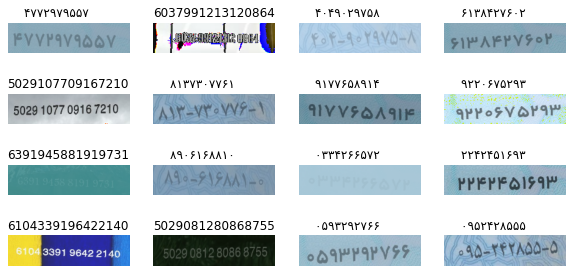

In [18]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(tf.transpose(img, perm=[1, 0, 2]))
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Build Model

In [19]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 3), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  896         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

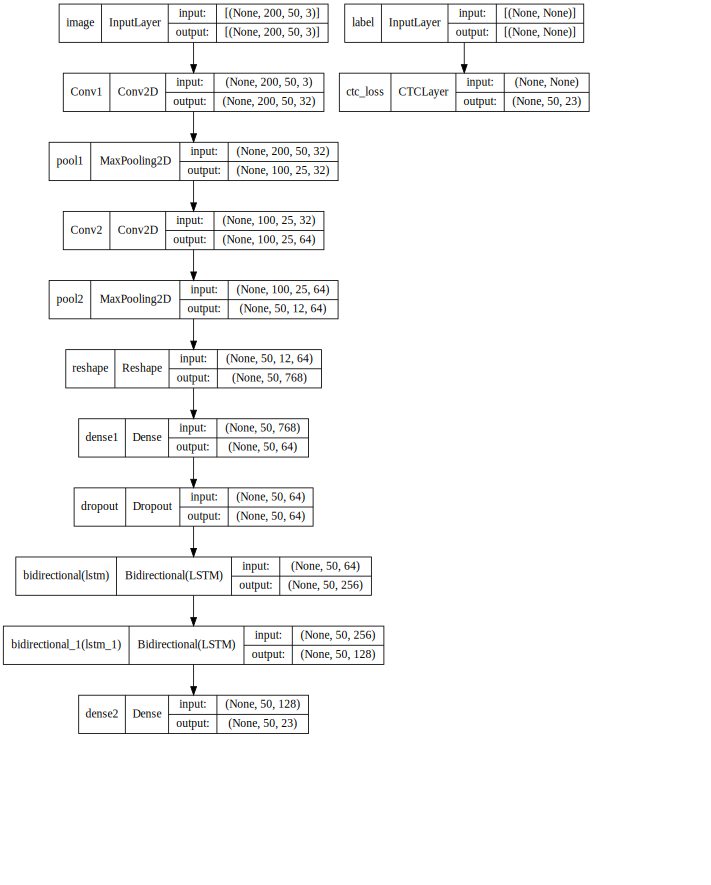

In [20]:
SVG(tf.keras.utils.model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

# Train

In [21]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
254/254 [==============================] - 388s 1s/step - loss: 39.6545 - val_loss: 67.4587
Epoch 2/100
254/254 [==============================] - 14s 53ms/step - loss: 33.8807 - val_loss: 31.3936
Epoch 3/100
254/254 [==============================] - 14s 53ms/step - loss: 32.1537 - val_loss: 30.7127
Epoch 4/100
254/254 [==============================] - 13s 53ms/step - loss: 31.5140 - val_loss: 31.3389
Epoch 5/100
254/254 [==============================] - 13s 53ms/step - loss: 31.3011 - val_loss: 30.1815
Epoch 6/100
254/254 [==============================] - 13s 53ms/step - loss: 30.7799 - val_loss: 30.0207
Epoch 7/100
254/254 [==============================] - 13s 52ms/step - loss: 30.3217 - val_loss: 29.9224
Epoch 8/100
254/254 [==============================] - 13s 52ms/step - loss: 30.1286 - val_loss: 29.7175
Epoch 9/100
254/254 [==============================] - 14s 53ms/step - loss: 30.0505 - val_loss: 29.6725
Epoch 10/100
254/254 [==============================] - 

In [22]:
model.save(base_dir + 'ocr.h5')

# Load Model

In [ ]:
urllib.request.urlretrieve('https://github.com/meliiwamd/OpticalCharacterRecognition/raw/main/ocr.h5', '/content/ocr.h5')
model = load_model('/content/ocr.h5', custom_objects={"CTCLayer": CTCLayer})

# Prediction

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 3)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       896       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

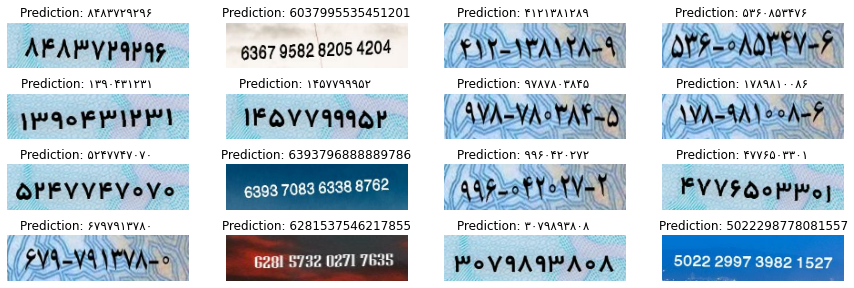

In [23]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i] * 255).numpy().astype(np.uint8)
        img = tf.transpose(img, perm=[1, 0, 2])
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [24]:
# Calculate Accuracy
accuracy = 0
counter = 0

def CountCommonElements(pred, orig):
    count = 0

    for i in range(len(pred)):
        if pred[i] == orig[i]:
            count += 1
    return count

for batch in validation_dataset:
      # Prediction's Accuracy 
      batch_images = batch["image"]
      batch_labels = batch["label"]


      preds = prediction_model.predict(batch_images)
      pred_texts = decode_batch_predictions(preds)

      orig_texts = []
      for label in batch_labels:
          label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
          orig_texts.append(label)

      for j in range(len(pred_texts)):
          counter +=1
          pred_texts[j] = pred_texts[j].replace("[UNK]", " ")
          accuracy += CountCommonElements(pred_texts[j], orig_texts[j])

denominator = counter * 16
accuracy /= denominator

print("Model's accuracy on validation data: %", accuracy * 100)

Model's accuracy on validation data: % 81.93055555555556


Text(0.5, 1.0, 'ocr_model_v1 loss')

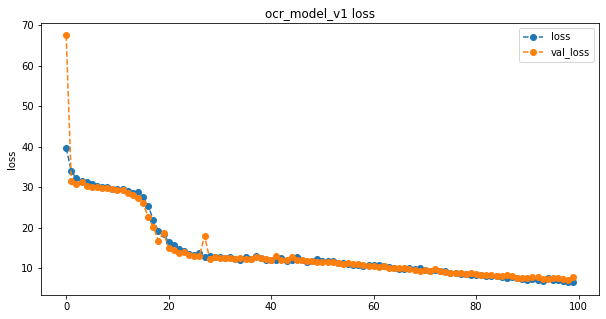

In [27]:
plt.figure(figsize=(10,5))

plt.plot(model.history.history['loss'], 'o--')
plt.plot(model.history.history['val_loss'], 'o--')

plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title(model.name + ' loss')

# Prediction Function

In [28]:
def prediction(images):
    print("Number of images found: ", len(images), '\n')
    
    result = []

    test_dataset = tf.data.Dataset.from_tensor_slices((images, ['0' * 16] * len(images)))
    test_dataset = (
        test_dataset.map(
            EncodeSingleSample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )

    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        result = result + pred_texts

        plt.figure(figsize=(5,2 * len(batch_images)))
        for i in range(len(pred_texts)):
            plt.subplot(len(batch_images), 1, i + 1)

            img = (batch_images[i] * 255).numpy().astype(np.uint8)
            img = tf.transpose(img, perm=[1, 0, 2])
            title = f"Prediction: {pred_texts[i]}"
            plt.imshow(img)
            plt.title(title)
            # plt.axis("off")

    return result


In [29]:
data_dir = Path(base_dir + 'Tests/')
images = list(map(str, list(data_dir.glob("*.jpg"))))

Number of images found:  19 



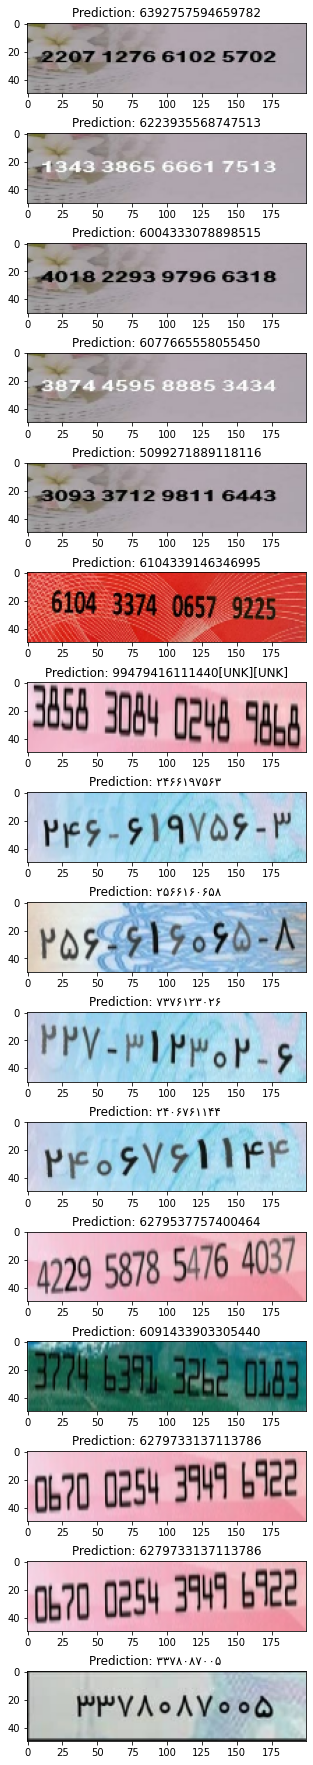

In [30]:
results = prediction(images)